**Mounting to Google Colab**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import All Required Packages**

In [2]:
import csv
import pandas as pd
import numpy as np
# used for encoding
import chardet
# natural language toolkit
import nltk
# wordnet is the database of English language
nltk.download('wordnet')
# stopwords for removing it from review
from nltk.corpus import stopwords
nltk.download('stopwords')
##from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
# ngrams used for bigram input
from nltk.util import ngrams
import string
import math
# importing Linear SVM Classifier 
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
# evaluation measures
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
# for plots and visualizations
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
#universal variable declaration
dataset=[]
trainData=[]
testData=[]
trainData_label=[]
testData_label=[]

# variable declaration for All the feature input
trainDataAll=[]
testDataAll=[]
trainData_labelAll=[]
testData_labelAll=[]

# for removal of punctuation words
table = str.maketrans({key: None for key in string.punctuation})

# Label list
label=[]

tfs = {}      # term frequency
#tfids = {}    #
tfidf = {}    # term frequency Inverse document frequency

tfs_test = {}    # term frequency for test data
#tfids_test = {}
tfidf_test = {}  # term frequency Inverse document frequency for test data

featureDict = {}         # A global dictionary of features
featureDict_test = {}    # A global dictionary of All features

**IMPORT DATASET  **

In [4]:
df = pd.read_csv(r"/content/drive/My Drive/Colab Notebooks/amazon_data.csv", encoding='Latin-1')
df = df.sample(frac=1).reset_index(drop=True)

# Replace the Labels with FAKE and REAL
df = df.replace({'LABEL': {'__label1__':'FAKE' , '__label2__':'REAL'}})

display(df.head())
label=df['LABEL'].tolist()

# Drop the LABEL
#df=df.drop('LABEL',axis=1)
#row,col = df.shape


,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
0,2907,FAKE,4,N,Watches,B000GAWSHM,Casio Men's MQ24-1E Black Resin Watch,I love this watch,"I love this watch. I just had one problem, it'..."
1,19346,REAL,4,Y,Shoes,B003XE3H6O,"crocs Women's Kadee Ballet Flat,Espresso/Espre...",Good purchase,I usually wear size 8.5 and I bought size 8 of...
2,15706,REAL,5,Y,Kitchen,B000PHGEM6,Hortense B. Hewitt Wedding Accessories Raindro...,Wedding flutes.,I liked it so much I might consider buying an ...
3,15480,REAL,4,Y,Musical Instruments,B002MA5LGE,Vento 901-VE5305I 500 Series Curved Soprano Sa...,"Not professional quality, but perfect for my l...","I am a hobbyist saxophone player, playing in a..."
4,4572,FAKE,5,Y,Beauty,B00SF458AK,Best Organic Sunless Tanning Lotion - Natural ...,Recommended.,I received this to review and I'm shocked at h...


**
VISUALIZATION OF DATASET**

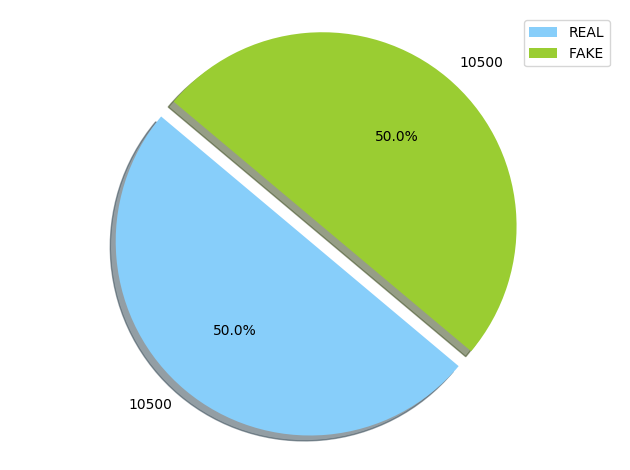

In [5]:
count_real=0
count_fake=0
for x in label:
  if x == 'REAL':
    count_real +=1
  else:
    count_fake +=1

count_rf=[count_real,count_fake] 
# Data to plot
labelss = 'REAL', 'FAKE'
labelss1=count_real,count_fake

colors = ['lightskyblue','yellowgreen']
explode = (0.1, 0)  # explode 1st slice
 

plt.pie(count_rf, explode=explode, labels=labelss1, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.legend(labelss)
plt.tight_layout()
plt.show()


**PARSE DATASET AND EXTRACT ESSENTIAL FEATURES FROM IT**


**Function for Parsing Only Review Text**

In [0]:
def parse(review):
    return (review[7])


**Function for Parsing Rating, Verified Purchase, Product Category, Review Title and Review Text **

In [0]:
def parseAll(review):
  return (review[2],review[3],review[4],review[8],review[1])

**TEXT PREPROCESSING**

In [0]:
def preprocess(text):
    lemmatizer = WordNetLemmatizer()
    filtered_tokens=[]
    lemmatized_tokens = []
    stop_words = set(stopwords.words('english'))
    text = text.translate(table) # translation of text is done here punctuations are replaced with none
    for w in text.split(" "):
        if w not in stop_words:
            lemmatized_tokens.append(lemmatizer.lemmatize(w.lower()))
            
        filtered_tokens = [' '.join(l) for l in nltk.bigrams(lemmatized_tokens)] + lemmatized_tokens
        #nltk bigrams will make pair of word occur together mrore frequently
        #here ' '.join(l) means it will join the words from the list (here it is l of iterable) with ' ' delimeter in between. 
    return filtered_tokens 
    

**FUNCTION FOR CONVERTING IN TO VECTOR**

In [0]:
def toFeatureVector(Rating, verified_Purchase, product_Category, tokens):
    localDict = {}
    
#Rating

    #print(Rating)
    featureDict["R"] = 1   
    localDict["R"] = Rating

#Verified_Purchase
  
    featureDict["VP"] = 1
            
    if verified_Purchase == "N":
        localDict["VP"] = 0
    else:
        localDict["VP"] = 1

#Product_Category

    
    if product_Category not in featureDict:
        featureDict[product_Category] = 1
    else:
        featureDict[product_Category] = +1
            
    if product_Category not in localDict:
        localDict[product_Category] = 1
    else:
        localDict[product_Category] = +1
            
            
#Text        

    for token in tokens:
        if token not in featureDict:
            featureDict[token] = 1
        else:
            featureDict[token] = +1
            
        if token not in localDict:
            localDict[token] = 1
        else:
            localDict[token] = +1
    
    return localDict


**DATA SET IN LIST FORM WITH THE DESIRED INPUTS**

In [0]:
dataset1 = list(df.values)
rawData = []
r,c = df.shape
length=len(df)
length
for i in range(length):
  
  ( Rating, verified_Purchase, product_Category, Text, Label) = parseAll(dataset1[i])
  rawData.append(( Rating, verified_Purchase, product_Category, Text, Label))
  
dataset= rawData


**SPLIT Function for All types of Feature Input**

In [0]:
def split(percent):
    dataSamples = len(dataset)
    halfOfData = int(len(dataset)/2)
    trainingSamples = int((percent*dataSamples)/2)
    
  
    for (Rating, verified_Purchase, product_Category, Text, Label) in dataset[:trainingSamples] + dataset[halfOfData:halfOfData+trainingSamples]:
        trainData.append((toFeatureVector(Rating, verified_Purchase, product_Category, preprocess(Text)),Label))
    for ( Rating, verified_Purchase, product_Category, Text, Label) in dataset[trainingSamples:halfOfData] + dataset[halfOfData+trainingSamples:]:
        testData.append((toFeatureVector(Rating, verified_Purchase, product_Category, preprocess(Text)),Label))
   

**TRAINING CLASSIFIER FUNCTION USING LINEAR SVM**

In [0]:
def trainClassifier(trainclassifier):
    print("Training Classifier")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(trainclassifier)

**TRAINING CLASSIFIER FUNCTION USING LINEAR SVM**

In [0]:
def crossValidate(dataset_cv, folds):
    cv_results = []
    foldSize = int(len(dataset_cv)/folds)
    for i in range(0,len(dataset_cv),foldSize):
        classifier = trainClassifier(dataset_cv[:i]+dataset_cv[foldSize+i:])
        y_pred = predictLabels(dataset_cv[i:i+foldSize],classifier)
        a = accuracy_score(list(map(lambda d : d[1], dataset_cv[i:i+foldSize])), y_pred)
        (p,r,f,_) = precision_recall_fscore_support(list(map(lambda d : d[1], dataset_cv[i:i+foldSize])), y_pred, average ='macro')
        #print(a,p,r,f)
        cv_results.append((a,p,r,f))
    cv_results = (np.mean(np.array(cv_results),axis=0))
    return cv_results

**TRAINING CLASSIFIER FUNCTION USING LINEAR SVM**

In [0]:
def predictLabels(reviewSamples, classifier1):
    return classifier1.classify_many(map(lambda t: t[0], reviewSamples))



**SPLIT FUNCTION CALLED**

In [0]:
split(0.80)

**CROSS-VALIDATE CALLED **

In [17]:
# Fold = 10

print("Now %d rawData, %d trainData, %d testData" % (len(dataset), len(trainData), len(testData)),
               "Training Samples: ", len(dataset), "Features: ", len(featureDict), sep='\n')
CV_RES = crossValidate(trainData, 10)
print("Mean of cross-validations (Accuracy, Precision, Recall, Fscore): ", CV_RES)

Now 21000 rawData, 16800 trainData, 4200 testData
Training Samples: 
21000
Features: 
512124
Training Classifier
Training Classifier
Training Classifier
Training Classifier
Training Classifier
Training Classifier
Training Classifier
Training Classifier
Training Classifier
Training Classifier
Mean of cross-validations (Accuracy, Precision, Recall, Fscore):  [0.80809524 0.80829532 0.80811726 0.80803727]


**VISUALIZATION OF CROSS-VALIDATION WITH 10 FOLDS**

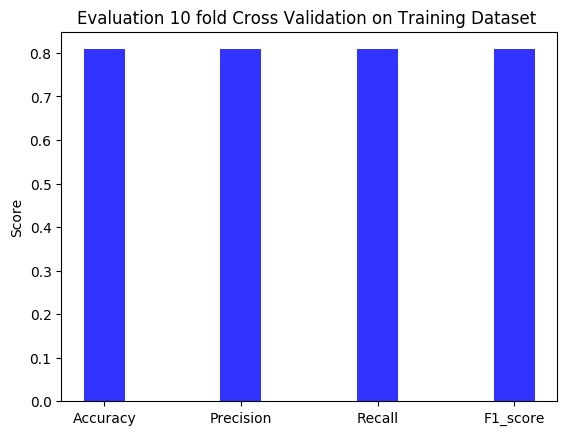

In [18]:
objects = ('Accuracy', 'Precision', 'Recall', 'F1_score')

performance = CV_RES
bar_width=0.3
rects1 = plt.bar(objects, performance,bar_width ,alpha=0.8,color='b',)
 
plt.xticks(objects, objects)
plt.ylabel('Score')
plt.title('Evaluation 10 fold Cross Validation on Training Dataset ')


plt.show()

**TESTING ACCURACY USING TEST SET**

In [19]:
## Test Accuracy
classifier = trainClassifier(trainData)
predictions = predictLabels(testData, classifier)
true_labels = list(map(lambda d: d[1], testData))
a = accuracy_score(true_labels, predictions)
p, r, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='macro')
print("accuracy: ", a)
print("Precision: ", p)
print("Recall: ", r)
print("f1-score: ", f1)

TEST_RES = [a,p,r,f1]

Training Classifier
accuracy:  0.815
Precision:  0.8153874284686937
Recall:  0.8150495106082498
f1-score:  0.8149583656322673


**VISUALIZATION OF PREDICTION RESULT ON TEST DATA SET**

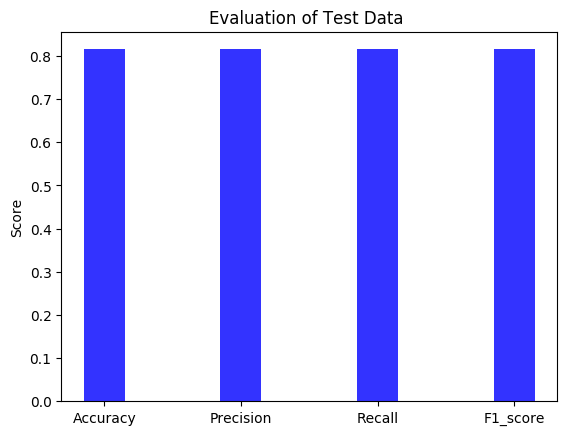

In [20]:
objects = ('Accuracy', 'Precision', 'Recall', 'F1_score')

performance = TEST_RES
bar_width=0.3
rects1 = plt.bar(objects, performance,bar_width ,alpha=0.8,color='b',)
 

plt.xticks(objects, objects)
plt.ylabel('Score')
plt.title('Evaluation of Test Data ')


plt.show()